In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [119]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random

In [120]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('/content/drive/MyDrive/oregon_wildlife/oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
/content/drive/MyDrive/oregon_wildlife/oregon_wildlife/virginia_opossum
/content/drive/MyDrive/oregon_wildlife/oregon_wildlife/sea_lions
/content/drive/MyDrive/oregon_wildlife/oregon_wildlife/red_fox
/content/drive/MyDrive/oregon_wildlife/oregon_wildlife/raven
/content/drive/MyDrive/oregon_wildlife/oregon_wildlife/raccoon
/content/drive/MyDrive/oregon_wildlife/oregon_wildlife/nutria
/content/drive/MyDrive/oregon_wildlife/oregon_wildlife/deer
/content/drive/MyDrive/oregon_wildlife/oregon_wildlife/cougar
/content/drive/MyDrive/oregon_wildlife/oregon_wildlife/black_bear
/content/drive/MyDrive/oregon_wildlife/oregon_wildlife/bald_eagle
/content/drive/MyDrive/oregon_wildlife/oregon_wildlife/test.tfrecord
/content/drive/MyDrive/oregon_wildlife/oregon_wildlife/val.tfrecord

total img num: 7168


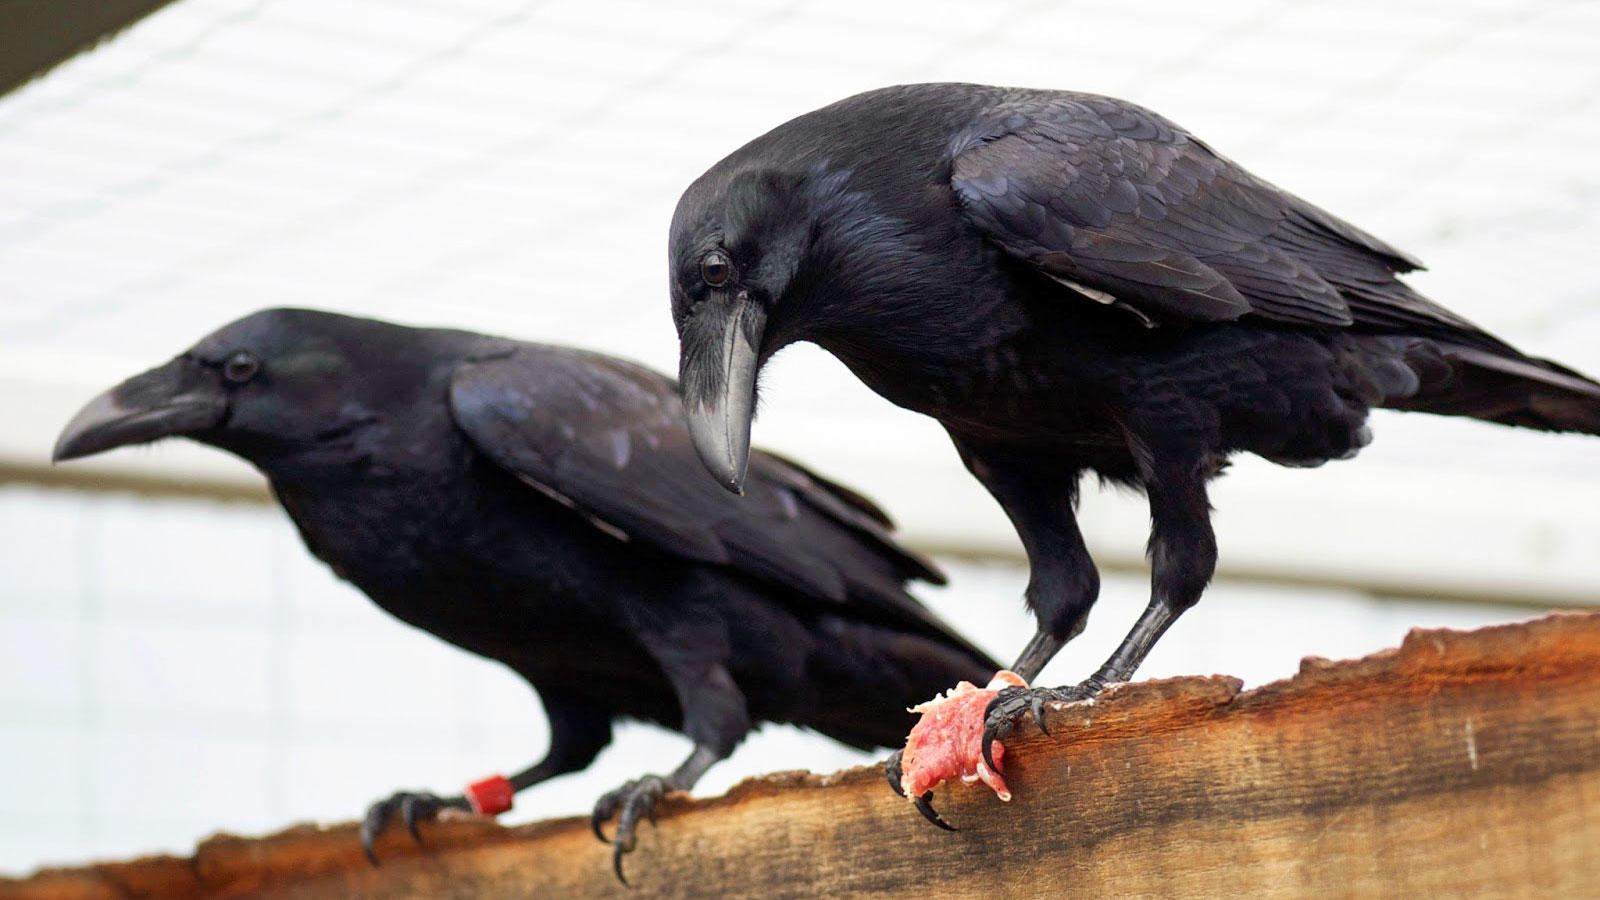

raven


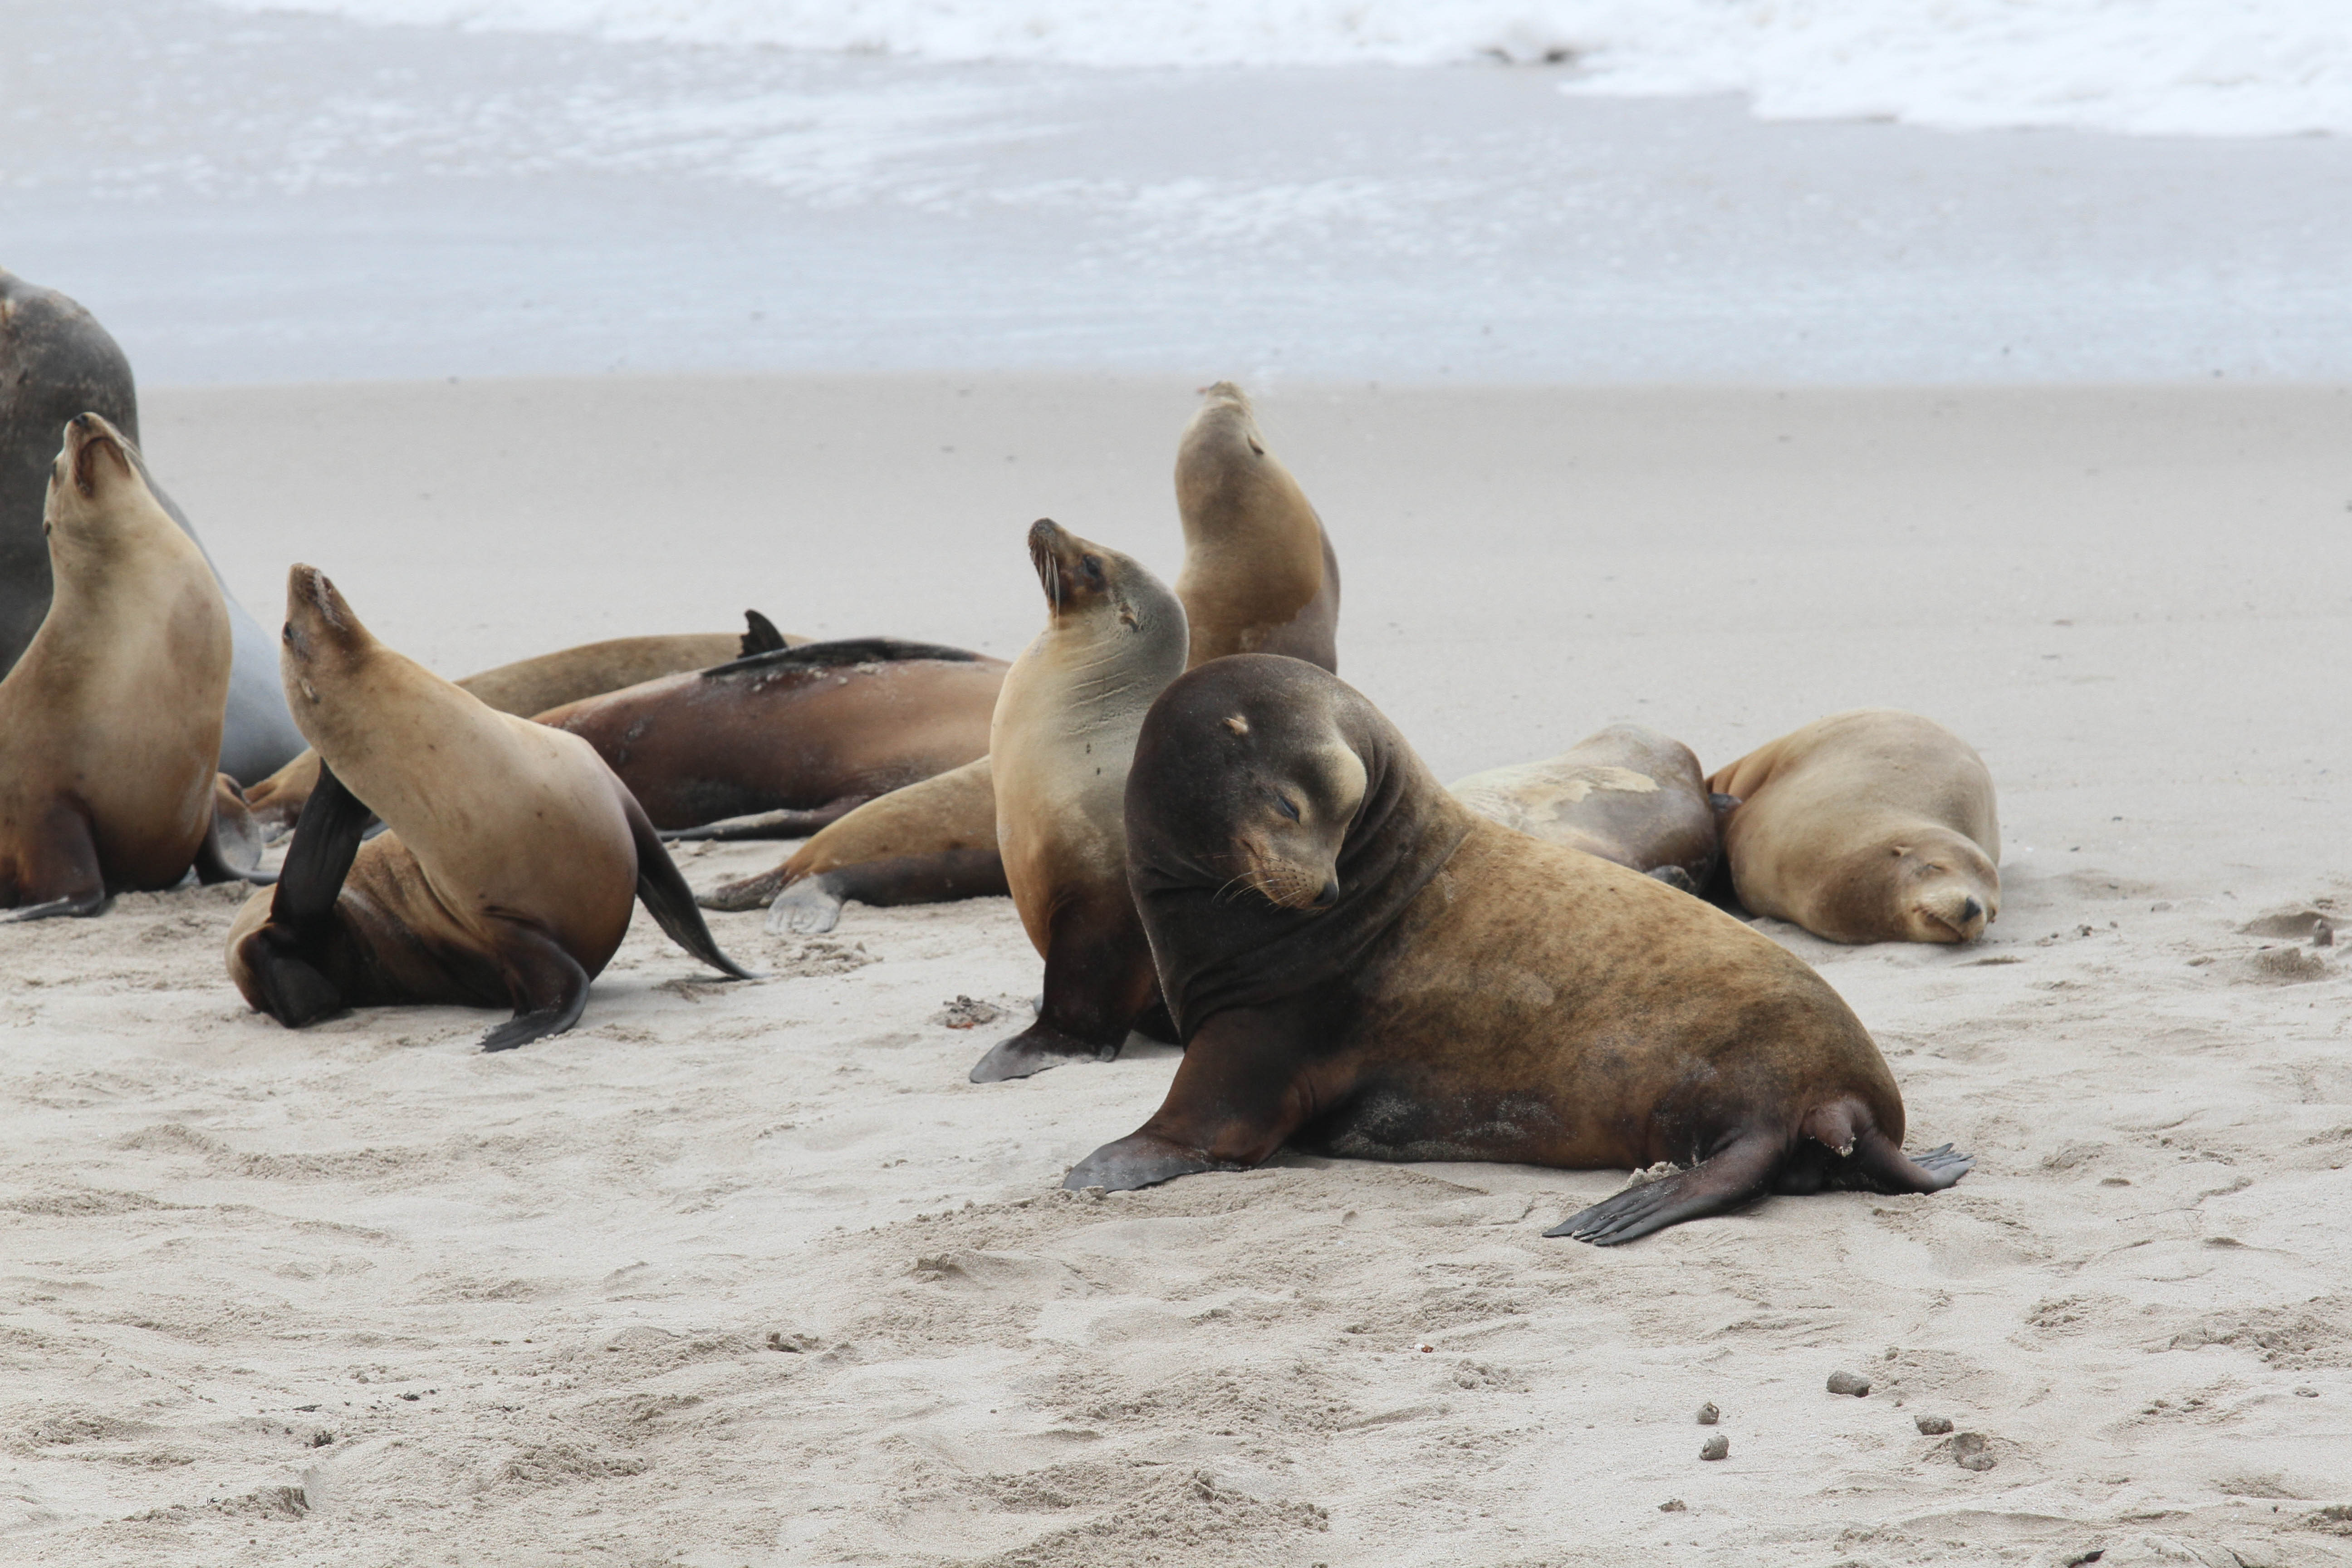

sea_lions


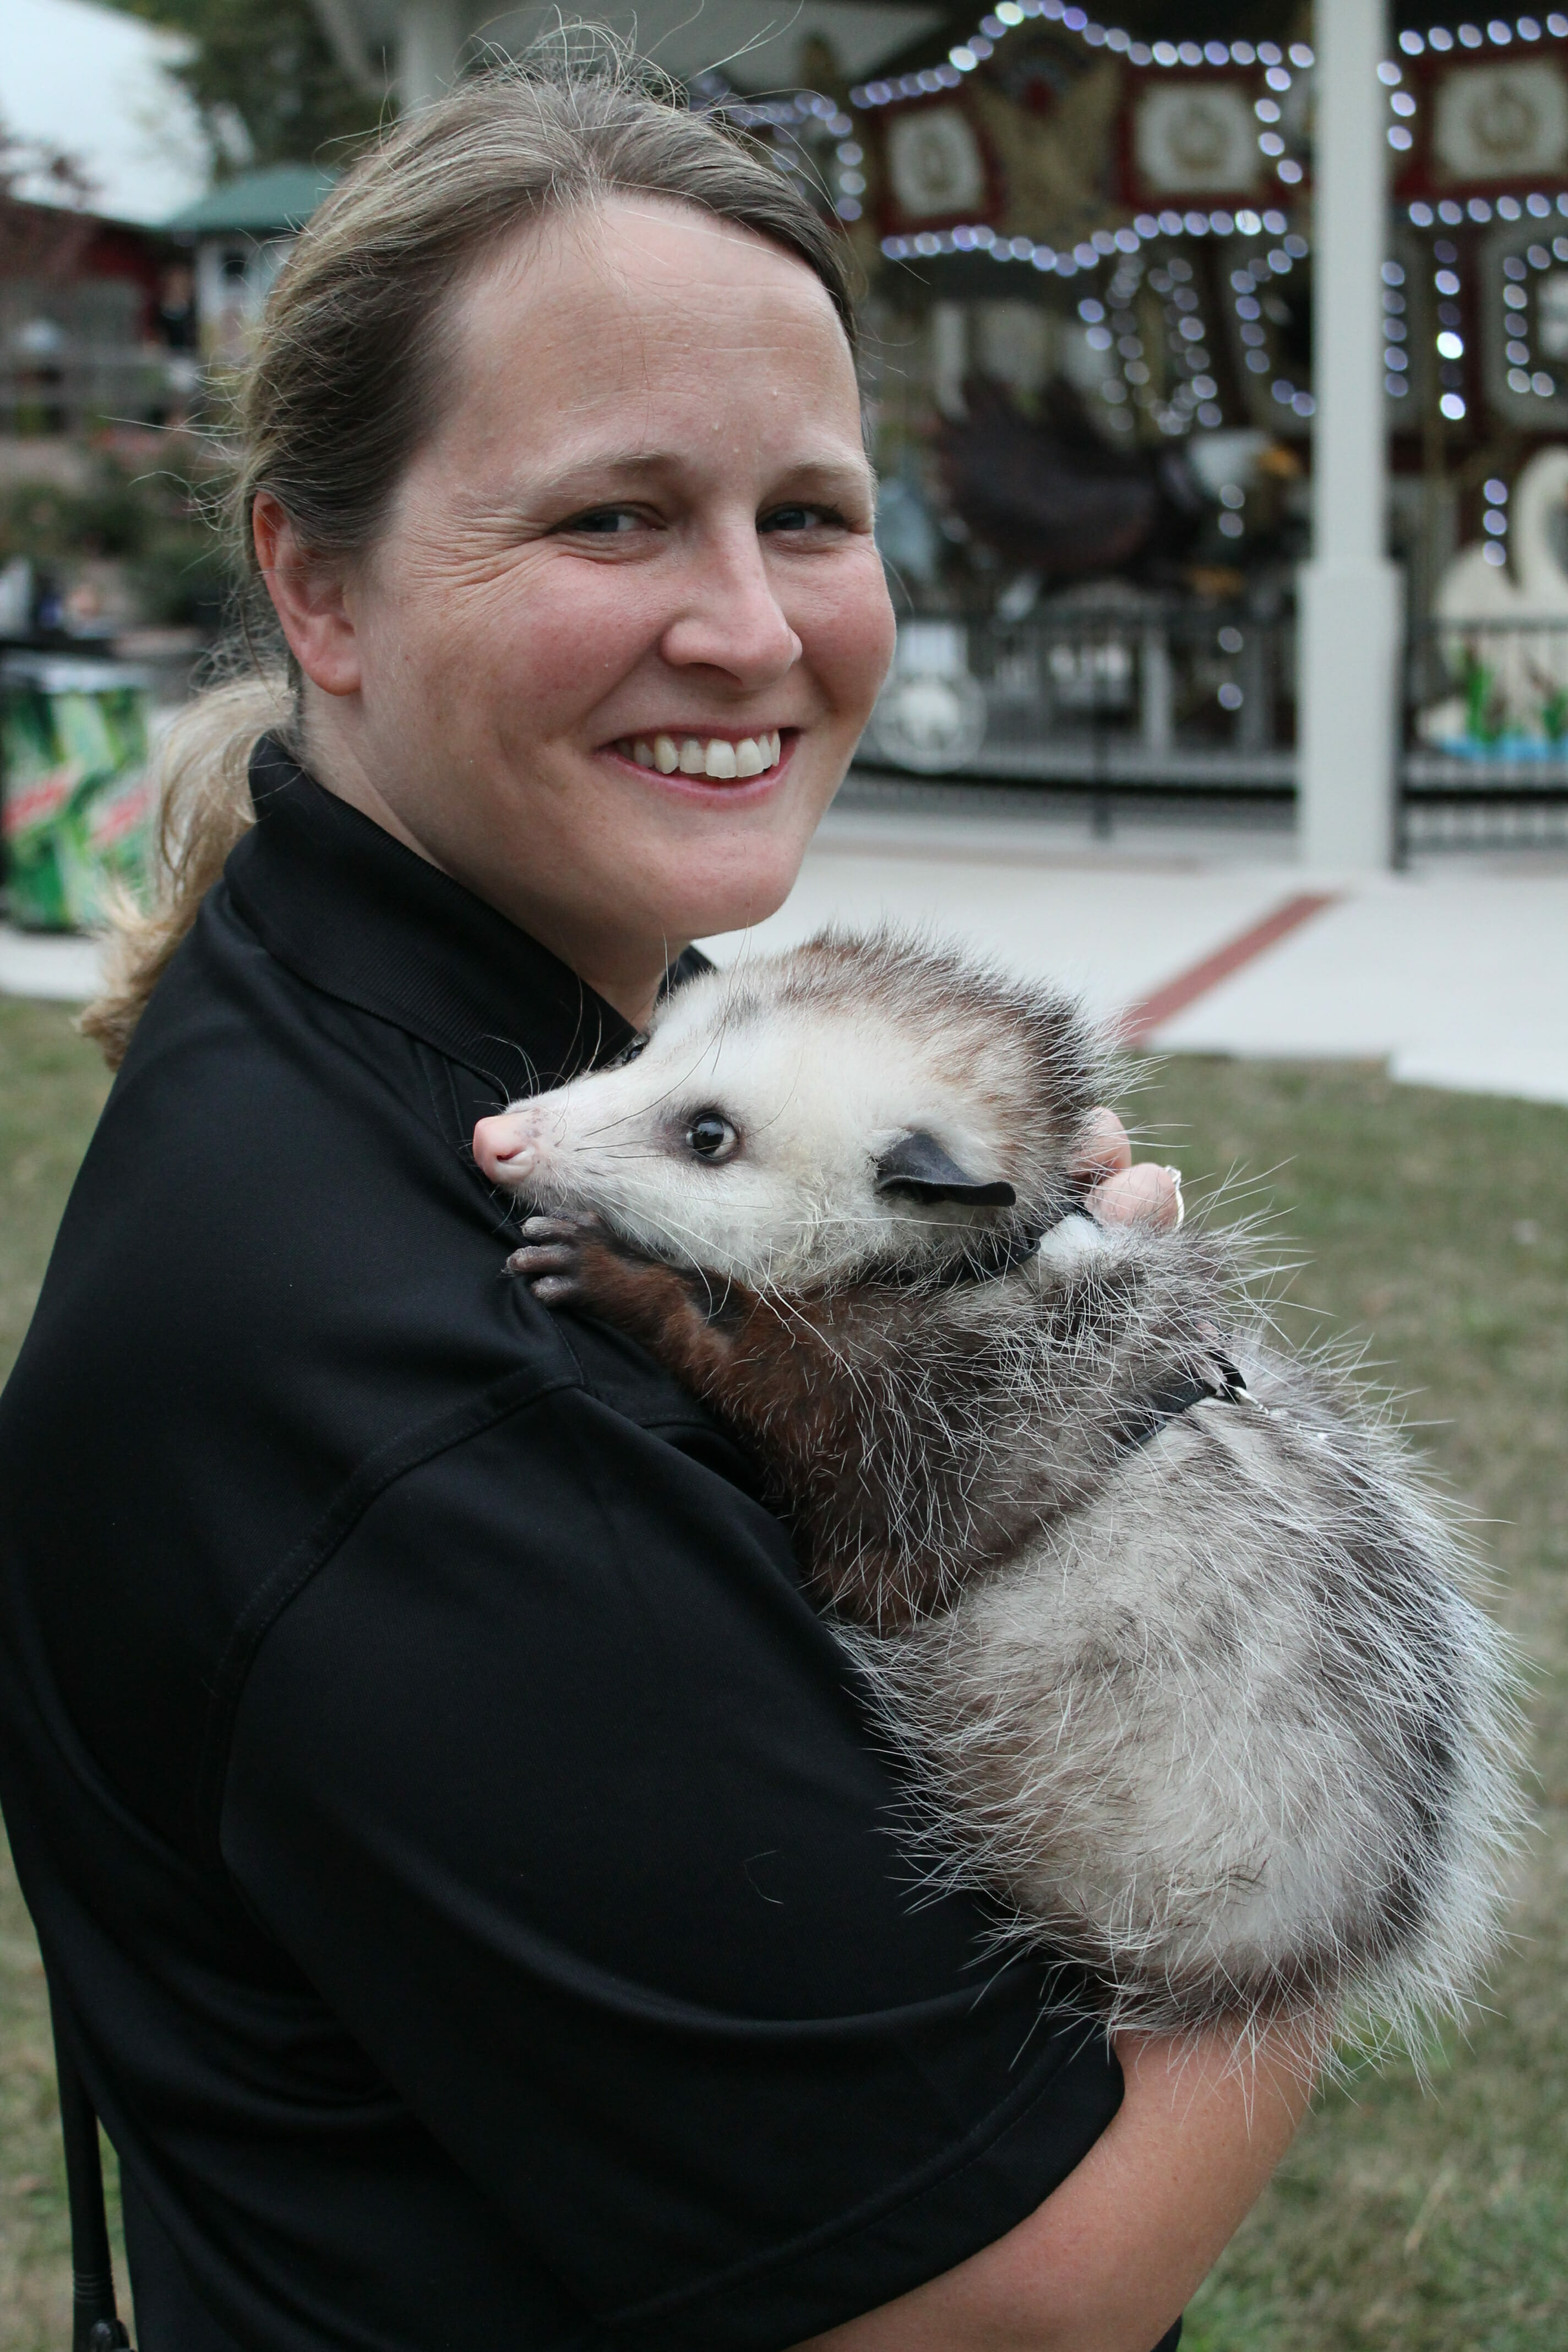

virginia_opossum


In [121]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('/')[-2])

In [122]:
# get the labels
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total labels
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [123]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [124]:
# get the label data
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [1, 4, 7, 4, 9, 7, 8, 9, 8, 9]


In [125]:
# Create training and validation sets using an 80-20 split
img_path_train, img_path_val, label_train, label_val = train_test_split(all_image_paths,
                                all_image_labels,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_val)))

training data: 5734
testing data: 1434


In [126]:
# You will use these setting in your code, pls do not modify these 4.
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3


# feel free to modify these Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 32

In [157]:
# loda images
def load_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img, label

In [158]:
# the dataset objects we prepared for you
dataset_train = tf.data.Dataset.from_tensor_slices((img_path_train,label_train))
dataset_train = dataset_train.map(load_image)
dataset_train
dataset_val = tf.data.Dataset.from_tensor_slices((img_path_val,label_val))
dataset_val = dataset_val.map(load_image)

In [53]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.tostring()]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [54]:
def serialize_example(feature0, feature1):
    """
    Creates a tf.Example message ready to be written to a file.
    """
    # Create a dictionary mapping the feature name to the tf.Example-compatible data type.
    feature = {
        'feature0': _bytes_feature(feature0),
        'feature1': _int64_feature(feature1),
    }

    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    
    return example_proto.SerializeToString()

In [55]:
def tf_serialize_example(f0,f1):
    tf_string = tf.py_function(
        serialize_example,
        (f0,f1),  # pass these args to the above function.
        tf.string)      # the return type is `tf.string`.
    return tf.reshape(tf_string, ()) # The result is a scalar

In [56]:
serialized_features_dataset = dataset_train.map(tf_serialize_example)
serialized_features_dataset

<MapDataset shapes: (), types: tf.string>

In [74]:
serialized_features_dataset_val = dataset_val.map(tf_serialize_example)
serialized_features_dataset_val

<MapDataset shapes: (), types: tf.string>

In [61]:
filename = '/content/drive/MyDrive/oregon_wildlife/oregon_wildlife/test.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  """


In [75]:
filename_val = '/content/drive/MyDrive/oregon_wildlife/oregon_wildlife/val.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename_val)
writer.write(serialized_features_dataset_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  """


In [131]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [132]:
filenames_val = [filename_val]
raw_dataset_val = tf.data.TFRecordDataset(filenames_val)
raw_dataset_val

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [133]:
# Create a description of the features.
feature_description = {
    'feature0': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'feature1': tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def _parse_function(example_proto):
  # Parse the input `tf.Example` proto using the dictionary above.
  parse = tf.io.parse_single_example(example_proto, feature_description)
  return parse['feature0'], parse['feature1']

In [167]:
parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset = parsed_dataset.shuffle(16)
parsed_dataset = parsed_dataset.batch(2,drop_remainder=False)

In [168]:
parsed_dataset_val = raw_dataset_val.map(_parse_function)
parsed_dataset_val = parsed_dataset_val.shuffle(16)
parsed_dataset_val = parsed_dataset_val.batch(2,drop_remainder=False)

(300, 300, 3)


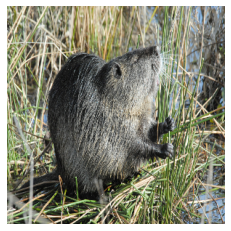

nutria


In [144]:
for img, label in dataset_train.take(1):
    print(img.shape)
    plt.imshow(img) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label.numpy()])

In [ ]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 
wild_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

wild_model.fit(dataset_train.batch(2,drop_remainder=False), validation_data=dataset_val.batch(2,drop_remainder=False), epochs=5)

In [ ]:
wild_model.fit(parsed_dataset.batch(2,drop_remainder=False), validation_data=parsed_dataset_val.batch(2,drop_remainder=False), epochs=5)

In [169]:
model_cifar = models.Sequential()

model_cifar.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(300, 300, 3)))
model_cifar.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_cifar.add(layers.BatchNormalization())
                
model_cifar.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model_cifar.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_cifar.add(layers.BatchNormalization())
                
model_cifar.add(layers.Flatten())
model_cifar.add(layers.Dense(384, activation='relu'))
model_cifar.add(layers.Dropout(0.5))
model_cifar.add(layers.Dense(192, activation='relu'))
model_cifar.add(layers.Dropout(0.5))
model_cifar.add(layers.Dense(10, activation='softmax'))

In [ ]:
model_cifar.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_cifar.fit(parsed_dataset.batch(2,drop_remainder=False), epochs=200, validation_data=parsed_dataset_val.batch(2,drop_remainder=False), verbose=0)